In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader

import csv
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

data_location = r'D:/MinecraftBot/McModel/mc-model/'

max_val = 200.0
num_classes = 2  # 2 classes just object and not object
data_length = 875 # starting at 0
train_length = 700

epochs = 100
batch_size = 32

### Model Definition

In [4]:
class DoubleConv(nn.Module):
    """Applies two consecutive convolution layers with Batch Normalization and ReLU activation."""

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Optional: can be removed
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Optional: can be removed
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with MaxPool followed by DoubleConv."""

    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    """Upscaling followed by DoubleConv."""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            # Use bilinear upsampling
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            # Use transposed convolution
            self.up = nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Padding in case the inexact size after upsampling
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(
            x1, 
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2]
        )

        # Concatenate along the channels axis
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """Final convolution layer to map to desired number of classes."""

    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.out_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.out_conv(x)

class MinecraftModel(nn.Module):
    """U-Net architecture."""

    def __init__(self, n_channels, n_classes, bilinear=True):
        super(MinecraftModel, self).__init__()
        self.in_conv = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1  # Adjust if using bilinear upsampling
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.out_conv = OutConv(64, 1) # 1 for depth estimation

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)  # Upsample and concatenate with corresponding encoder output
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.out_conv(x)
        return logits

### Dataset Definition

In [5]:
class MinecraftDepthDataset(Dataset):
    def __init__(self, image_paths, depth_paths, transform=None, train=True):
        self.image_paths = image_paths
        self.depth_paths = depth_paths
        self.transform = transform
        self.trainset = train

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        with open(self.depth_paths[idx], mode='r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)
            rows = list(csv_reader)

            distances = []
            for row in rows:
                val = float(row[1])
                distances.append(val / max_val if val > 0 else 1)

        if self.transform:
            image = self.transform(image)
        
        depth = torch.tensor(distances, dtype=torch.float32)

        return image, depth

weights = models.ResNet50_Weights.DEFAULT
transform = weights.transforms()

image_paths = [data_location + 'data/Unannotated/image_{}.png'.format(str(i).zfill(5)) for i in range(1, data_length)]
depth_paths = [data_location + 'data/Annotations/annotation_{}.csv'.format(str(i).zfill(5)) for i in range(1, data_length)]

# Example paths, replace with your actual paths
train_dataset = MinecraftDepthDataset(image_paths[:train_length], depth_paths[:train_length], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

val_dataset = MinecraftDepthDataset(image_paths[train_length:], depth_paths[train_length:], transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

### Training

In [7]:
model = MinecraftModel(3, num_classes).to(device)

depth_loss_fn = nn.MSELoss()
optimizer_depth = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    # Training step
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        start_time = time.time()
        for i, (images, depth_targets) in enumerate(train_loader):
            images = images.to(device)
            depth_targets = depth_targets.to(device)

            # optimizer_backbone.zero_grad()
            optimizer_depth.zero_grad()

            depth_pred = model(images)

            loss = depth_loss_fn(depth_pred, depth_targets)
            loss.backward()
            optimizer_depth.step()
            # optimizer_backbone.step()

            train_loss += loss.item() * images.size(0)

            pbar.set_postfix({'loss': loss.item(), 'iter/s': '{:.2f}'.format(i / (time.time() - start_time))})
            pbar.update(1)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, depth_targets in val_loader:
            images = images.to(device)
            depth_targets = depth_targets.to(device)

            depth_pred = model(images)
            loss = depth_loss_fn(depth_pred, depth_targets)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/100:   0%|          | 0/22 [06:07<?, ?batch/s]


KeyboardInterrupt: 

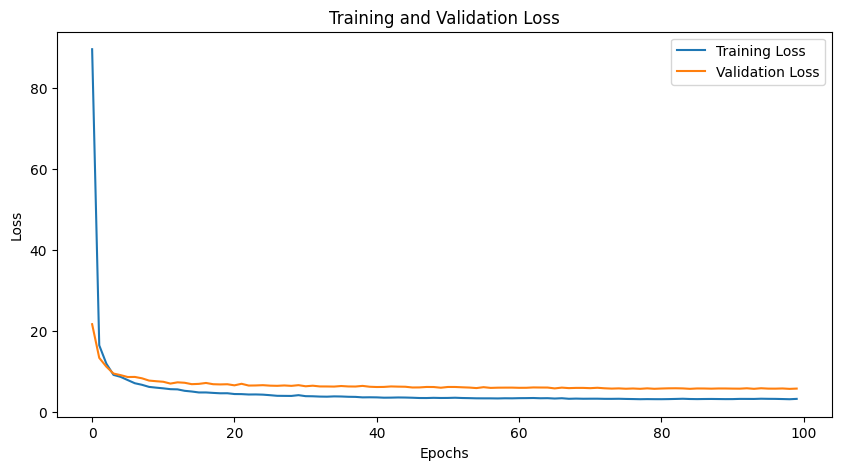

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [11]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))